<a href="https://colab.research.google.com/github/mianadnan30/-Correlation-in-Python/blob/master/LLCDdigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 7.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=bf7d7a662f5791f0d53404e3444f66051888051d71798ed51f8e831a9f1e588b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 4.3MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=6f2d3ba8c17720b5073e11b597ecb064b609241ac27c3a5eba58ed3eb6c80580
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
!unzip label3.zip

Archive:  label3.zip
   creating: label3/
   creating: label3/im/
  inflating: label3/im/0030910796.jpg  
  inflating: label3/im/0030911231.jpg  
  inflating: label3/im/0030911402.jpg  
  inflating: label3/im/0030911610.jpg  
  inflating: label3/im/0030911833.jpg  
  inflating: label3/im/0030912081.jpg  
  inflating: label3/im/0030912273.jpg  
  inflating: label3/im/0030912406.jpg  
  inflating: label3/im/0030912593.jpg  
  inflating: label3/im/0030912701.jpg  
  inflating: label3/im/0030912906.jpg  
  inflating: label3/im/0030913379.jpg  
  inflating: label3/im/0030913567.jpg  
  inflating: label3/im/0030913742.jpg  
  inflating: label3/im/0030914000.jpg  
  inflating: label3/im/0030914564.jpg  
  inflating: label3/im/0030914842.jpg  
  inflating: label3/trainval.json    


In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset0", {}, "/content/label3/trainval.json", "/content/label3/im")
# register_coco_instances("my_dataset_V", {}, "trainval.json", "path/DATA")

In [6]:
Sample_metadata =MetadataCatalog.get("my_dataset0")
# .thing_classes = ["0","1","2","3","4","5","6","7","8","9"]

Dataset_dicts=DatasetCatalog.get("my_dataset0")
# MetadataCatalog.get("my_dataset").thing_classes = ["person", "dog"]

# print(my_dataset1)

WARNING [05/25 09:50:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/25 09:50:13 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/label3/trainval.json


In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset0",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 700    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/25 09:50:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 77.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due 

[05/25 09:50:31 d2.engine.train_loop]: Starting training from iteration 0
[05/25 09:50:37 d2.utils.events]:  eta: 0:03:23  iter: 19  total_loss: 4.046  loss_cls: 2.319  loss_box_reg: 0.4745  loss_mask: 0.6932  loss_rpn_cls: 0.5517  loss_rpn_loc: 0.03445  time: 0.3000  data_time: 0.0141  lr: 4.9953e-06  max_mem: 2407M
[05/25 09:50:44 d2.utils.events]:  eta: 0:03:20  iter: 39  total_loss: 4.019  loss_cls: 2.197  loss_box_reg: 0.6944  loss_mask: 0.6906  loss_rpn_cls: 0.4066  loss_rpn_loc: 0.03991  time: 0.3034  data_time: 0.0074  lr: 9.9902e-06  max_mem: 2407M
[05/25 09:50:50 d2.utils.events]:  eta: 0:03:14  iter: 59  total_loss: 3.665  loss_cls: 1.974  loss_box_reg: 0.8317  loss_mask: 0.6872  loss_rpn_cls: 0.1632  loss_rpn_loc: 0.03267  time: 0.3035  data_time: 0.0059  lr: 1.4985e-05  max_mem: 2407M
[05/25 09:50:56 d2.utils.events]:  eta: 0:03:08  iter: 79  total_loss: 3.323  loss_cls: 1.657  loss_box_reg: 0.8487  loss_mask: 0.6823  loss_rpn_cls: 0.08523  loss_rpn_loc: 0.03583  time: 0.3

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.DATASETS.TEST = ("my_dataset0", )
predictor = DefaultPredictor(cfg)

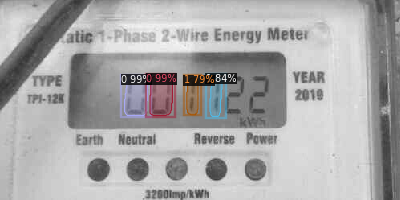

In [10]:
imge = "/content/0032533096.jpg"
from detectron2.utils.visualizer import ColorMode
im = cv2.imread(imge)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=MetadataCatalog.get("my_dataset0"),
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])


In [ ]:
!unzip test44.zip

Archive:  test44.zip
   creating: test44/
  inflating: test44/0030006701.jpg   
  inflating: test44/0030007618.jpg   
  inflating: test44/0030009718.jpg   
  inflating: test44/0030012042.jpg   
  inflating: test44/0030013204.jpg   
  inflating: test44/0030016373.jpg   
  inflating: test44/0030017596.jpg   
  inflating: test44/0030023478.jpg   
  inflating: test44/0030027740.jpg   
  inflating: test44/0030028473.jpg   
  inflating: test44/0030029140.jpg   
  inflating: test44/0030029391.jpg   
  inflating: test44/0030030432.jpg   
  inflating: test44/0030031996.jpg   
  inflating: test44/0030033710.jpg   
  inflating: test44/0030035375.jpg   
  inflating: test44/0030036263.jpg   
  inflating: test44/0030036942.jpg   
  inflating: test44/0030038596.jpg   
  inflating: test44/0030041820.jpg   
  inflating: test44/0030042062.jpg   
  inflating: test44/0030042241.jpg   
  inflating: test44/0030042959.jpg   
  inflating: test44/0030048489.jpg   
  inflating: test44/0030056626.jpg   


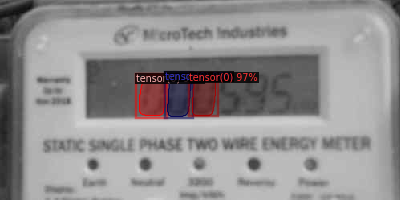

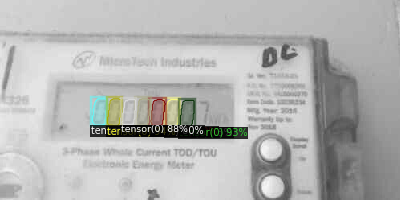

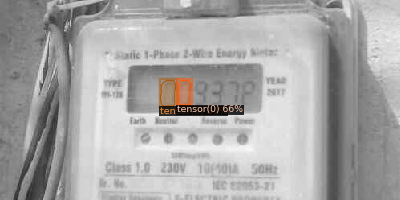

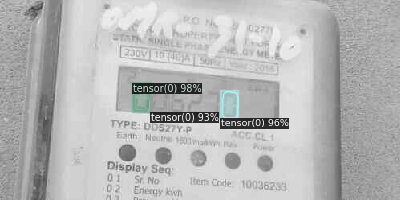

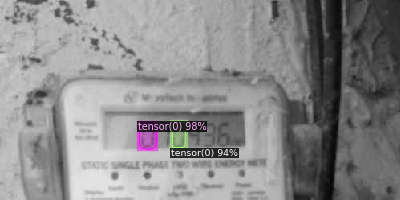

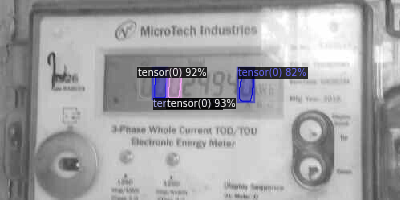

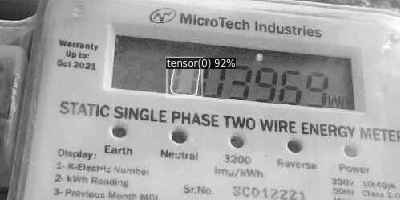

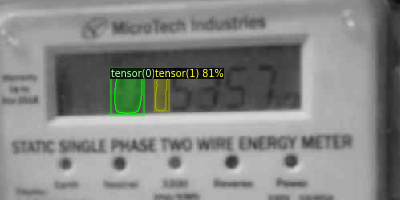

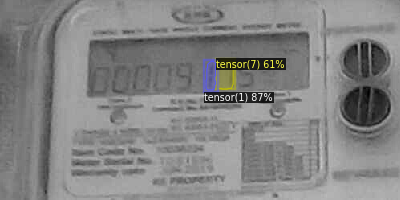

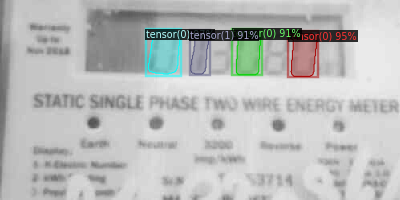

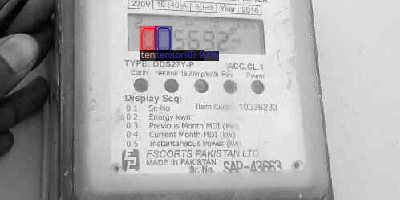

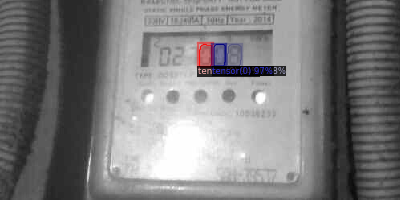

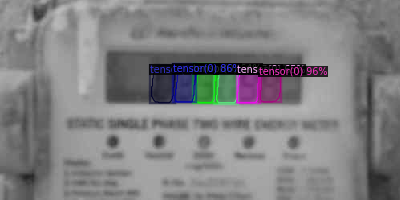

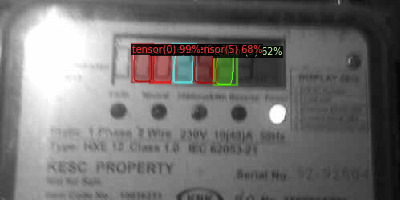

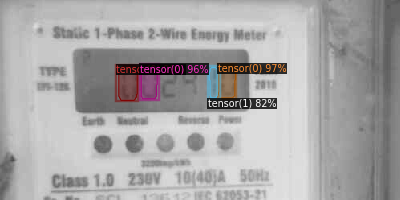

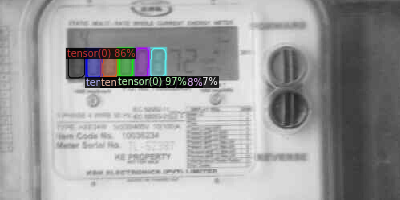

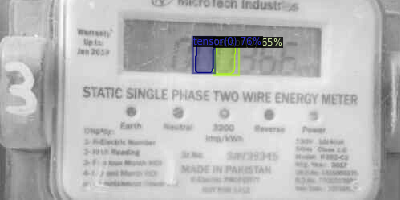

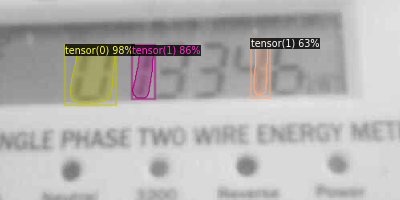

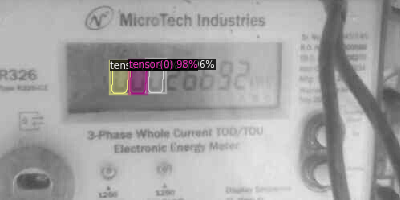

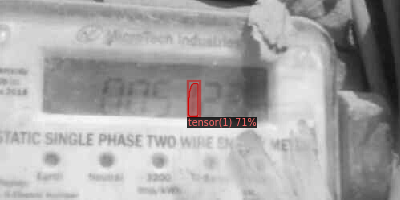

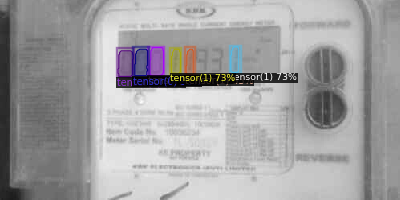

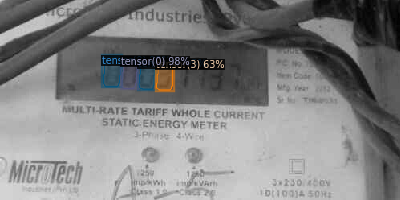

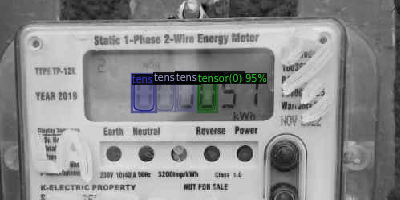

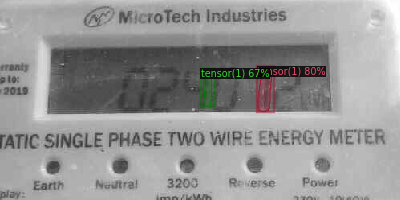

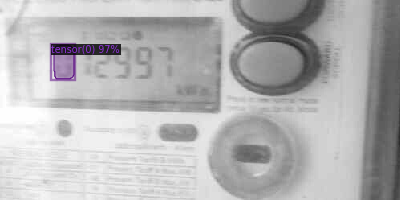

In [ ]:


from detectron2.utils.visualizer import ColorMode
# dataset_dicts =("/content/drive/My Drive/TEST")
# for d in random.sample(dataset_dicts,4):    

import glob
for img in glob.glob("/content/test44/*jpg"):
    cv_img = cv2.imread(img)  
    outputs = predictor(cv_img)
    v = Visualizer(cv_img[:, :, ::-1],
               metadata=MetadataCatalog.get("my_dataset"),
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
               )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    # v.shape()